# Data mining (Service Time prediction - Complément)
## Phases 4 & 5 CRISP - DM : Modélisation
## Outline
- [Préliminaire](#1)
- [4 - Modeling and Evaluation ](#4)
  - [4.4 - ANN (MLP)](#4.4)    
      - [4.4.1 - Training model](#4.1)
      - [4.4.2 - Evaluation ](#4.2)

In [57]:
#Load our local fonctions
from utils_st import *
# load librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [103]:
data = data[data['NoShow']==0]

In [104]:
data.drop('NoShow', axis=1, inplace=True)

In [93]:
data.drop('prior_service_time_avg', axis=1, inplace=True)

In [33]:
data = decompose_disp_column(data)
data['NoShow'] = data['NoShow'].values.astype(np.int8)

In [26]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'service_time' is the column you want to predict
X = data.drop('service_time', axis=1)  # Features: Drop the target variable column from the dataset
y = data['service_time']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [27]:
# Fonction pour enregistrer un DataFrame en CSV dans le répertoire 'preprocessed'
def save_dataframe(df, name):
    filename = f'data_st/{name}.csv'
    df.to_csv(filename, index=False)

In [59]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le MinMaxScaler
# Normalisation des données après le sampling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a name="4"></a>
## 4 - Modeling

In [ ]:
<a name="4.1"></a>
### 4.2.1 - Training model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model(input_dim):
    """
    Builds a MLP model for predicting service time.

    Args:
    input_dim (int): The number of features in the input data.

    Returns:
    keras.Model: A compiled neural network model.
    """
    model = Sequential([
        Dense(16, input_dim=input_dim, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(1) 
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the model
input_dim = X_train.shape[1]  
model = build_model(input_dim)

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# Fit the model with callbacks
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2)


Epoch 1/50
209448/209448 - 327s - 2ms/step - loss: 236.9002 - val_loss: 236.4172 - learning_rate: 0.0100
Epoch 2/50
209448/209448 - 318s - 2ms/step - loss: 236.3877 - val_loss: 232.6385 - learning_rate: 0.0100
Epoch 3/50
209448/209448 - 341s - 2ms/step - loss: 233.4756 - val_loss: 232.1513 - learning_rate: 0.0100
Epoch 4/50
209448/209448 - 341s - 2ms/step - loss: 233.0852 - val_loss: 231.7340 - learning_rate: 0.0100
Epoch 5/50
209448/209448 - 328s - 2ms/step - loss: 232.9457 - val_loss: 232.4485 - learning_rate: 0.0100
Epoch 6/50
209448/209448 - 347s - 2ms/step - loss: 232.9474 - val_loss: 231.5011 - learning_rate: 0.0100
Epoch 7/50
209448/209448 - 318s - 2ms/step - loss: 232.9001 - val_loss: 231.6441 - learning_rate: 0.0100
Epoch 8/50
209448/209448 - 337s - 2ms/step - loss: 233.2358 - val_loss: 232.7528 - learning_rate: 0.0100
Epoch 9/50
209448/209448 - 326s - 2ms/step - loss: 233.2990 - val_loss: 231.7123 - learning_rate: 0.0100
Epoch 10/50
209448/209448 - 364s - 2ms/step - loss: 233

In [33]:
# we save model 
model.save('modele_st_mlp_v6.keras')  
print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [8]:
from keras.models import load_model
# Charge le modèle
model = load_model('modele_st_mlp_v5.keras')
print("Modèle chargé avec succès.")

Modèle chargé avec succès.


<a name="4.2"></a>
### 4.2 - Evaluation

In [34]:
# Make predictions
y_pred_ann = model.predict(X_test).flatten()  # Flatten is used to match the shape of y_test
# Make predictions
y_pred_train_ann = model.predict(X_train).flatten()  # Flatten is used to match the shape of y_test

89764/89764 ━━━━━━━━━━━━━━━━━━━━ 79s 880us/step
209448/209448 ━━━━━━━━━━━━━━━━━━━━ 184s 877us/step


In [35]:
def evaluate_mlp_model(model, X_test, y_test, y_pred):
    """
    Evaluate an MLP model using R-squared, MAE, MSE, and RMSE.

    Args:
    model: The trained MLP model.
    X_test: Test features.
    y_test: True values for test features.

    Returns:
    dict: A dictionary containing evaluation metrics.
    """
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return {
        'R-squared': r2,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    
}

In [36]:
evaluate_mlp_model(model, X_test, y_test, y_pred_ann)

{'R-squared': 0.04744398976030628,
 'Mean Absolute Error': 12.216752452177277,
 'Mean Squared Error': 231.40562545312017,
 'Root Mean Squared Error': 15.212022398521512}

In [37]:
evaluate_mlp_model(model, X_train, y_train, y_pred_train_ann)

{'R-squared': 0.04739806269816327,
 'Mean Absolute Error': 12.20766130039965,
 'Mean Squared Error': 231.2224422027338,
 'Root Mean Squared Error': 15.206000203956785}

In [38]:
metric=r2_score

test_score = model.evaluate(X, y, verbose=0)

In [ ]:
importances_scores

In [ ]:
feature_names = data.columns.tolist()

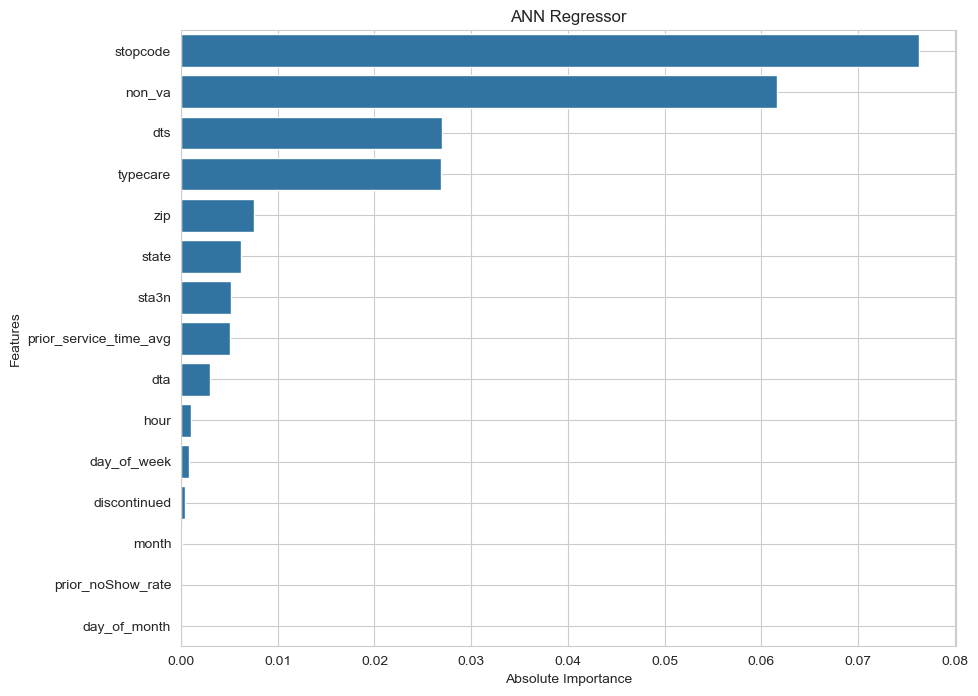

In [41]:
# Assume feature_names corresponds to the columns in your feature matrix X_test
feature_names = X_test.columns.tolist()

# Now plot the feature importances with the enhanced visual style
plot_permutation_importance(importances_scores, feature_names)


In [26]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

Train Loss: 1.000256061553955
Test Loss: 0.999395489692688


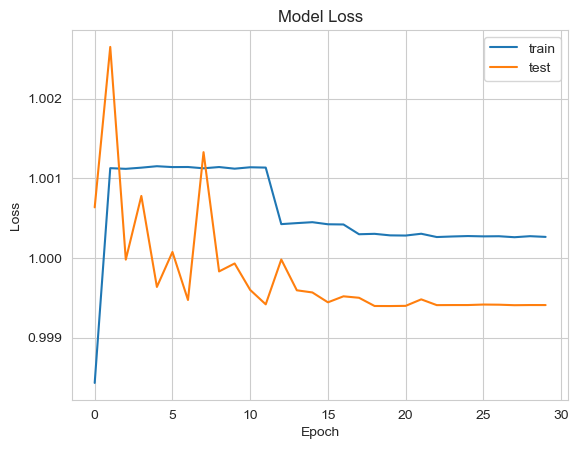

In [27]:
# The training history for loss
import matplotlib.pyplot as plt
  
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

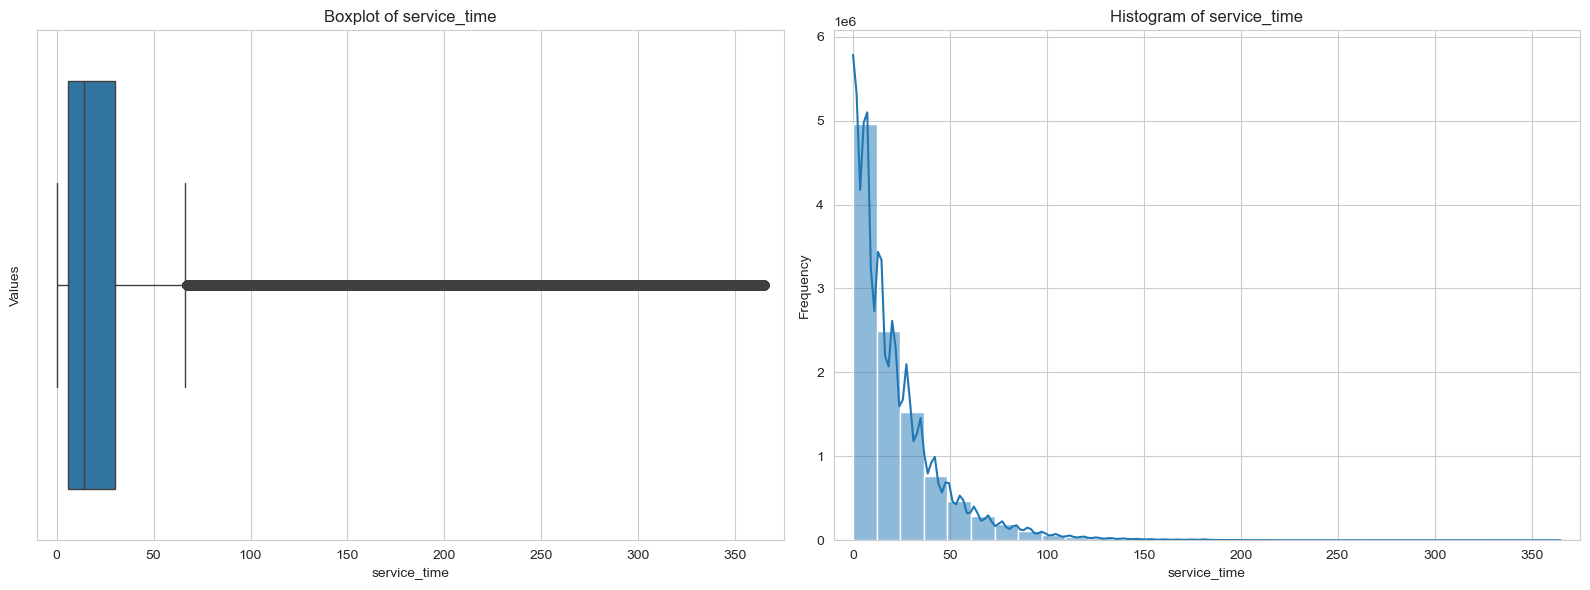

The variance of service_time is: 636.1816146161206


In [77]:
plot_service_time_distribution(data, 'service_time')